In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.losses import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
import h5py
from pyspark.sql.window import Window
import time

In [3]:

appName = "ClimateEventsApp"
master = 'local'

# Create Spark session
spark = SparkSession.builder \
    .master(master) \
    .appName(appName) \
    .getOrCreate()

In [4]:
filepath = "./"
files = ["DFCLEAN_daily.csv"]
schema = StructType() \
      .add("Time",StringType(),True) \
      .add("Temperature",FloatType(),True) \
      .add("Precipitation",FloatType(),True) \
      .add("Humidity",FloatType(),True) \
      .add("Wind",FloatType(),True) \
      .add("Datetime",TimestampType(),True)\
      .add("Date",DateType(),True) 

df = spark.read.format("csv") \
      .option("header", True) \
      .option("delimiter", "|") \
      .schema(schema) \
      .load("./DFCLEAN_daily.csv")
df.show()
df = df.filter(df.Temperature.isNotNull() & (F.length("Time")==13))
df = df.withColumn("Year",F.year("Date")).withColumn("Month",F.month("Date")).orderBy("Date")

+-------------+-----------+-------------+--------+----------+-------------------+----------+
|         Time|Temperature|Precipitation|Humidity|      Wind|           Datetime|      Date|
+-------------+-----------+-------------+--------+----------+-------------------+----------+
|20041110T0500| 0.83502877|          0.1|    95.0|12.7279215|2004-11-10 05:00:00|2004-11-10|
|20041110T0600| 0.89502877|          0.0|    95.0|  12.72283|2004-11-10 06:00:00|2004-11-10|
|20041110T0700|  1.3250288|          0.0|    92.0| 13.708391|2004-11-10 07:00:00|2004-11-10|
|20041110T0800|  2.6350288|          0.0|    84.0| 12.783802|2004-11-10 08:00:00|2004-11-10|
|20041110T0900|  3.2250288|          0.0|    76.0|  9.686609|2004-11-10 09:00:00|2004-11-10|
|20041110T1000|  4.5450287|          0.0|    69.0|  7.145796|2004-11-10 10:00:00|2004-11-10|
|20041110T1100|  5.7950287|          0.0|    65.0| 4.6102495|2004-11-10 11:00:00|2004-11-10|
|20041110T1200|   5.645029|          0.0|    72.0| 3.8773184|2004-11-1

In [5]:
df.show()

+-------------+-----------+-------------+--------+---------+-------------------+----------+----+-----+
|         Time|Temperature|Precipitation|Humidity|     Wind|           Datetime|      Date|Year|Month|
+-------------+-----------+-------------+--------+---------+-------------------+----------+----+-----+
|19850101T0000| 0.35502875|          0.6|    96.0| 40.57952|1985-01-01 00:00:00|1985-01-01|1985|    1|
|19850101T2000| 0.26502883|          0.5|    96.0|35.632725|1985-01-01 20:00:00|1985-01-01|1985|    1|
|19850101T0100| 0.36502874|          0.7|    97.0|41.301273|1985-01-01 01:00:00|1985-01-01|1985|    1|
|19850101T0200|  0.4150288|          0.9|    97.0|41.556225|1985-01-01 02:00:00|1985-01-01|1985|    1|
|19850101T0300|  0.5350288|          0.9|    98.0|39.797504|1985-01-01 03:00:00|1985-01-01|1985|    1|
|19850101T0400| 0.64502877|          0.8|    98.0|28.528723|1985-01-01 04:00:00|1985-01-01|1985|    1|
|19850101T0500|  0.5950288|          0.5|    98.0|26.758923|1985-01-01 05

# LSTM model

In [6]:
# max T and Max Rain are the variable on which we are going to use
# the first 6 month of 2021 and 2020 will be used as test set, all the rest as training data

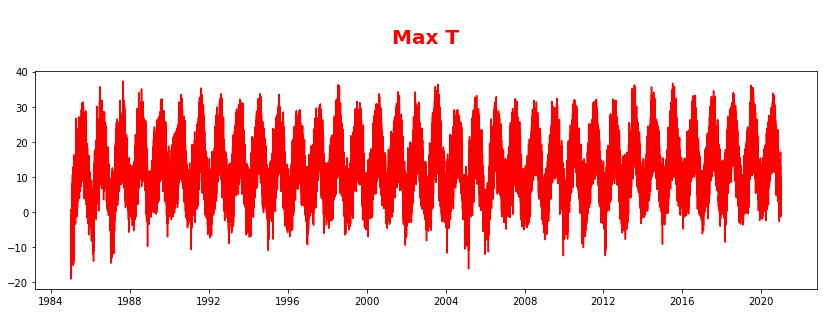

In [7]:
data = df.select("Datetime","Temperature").filter(df.Year != 2021).collect()
day = [i.Datetime for i in data]
MaxT_training_data = [i.Temperature for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_training_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

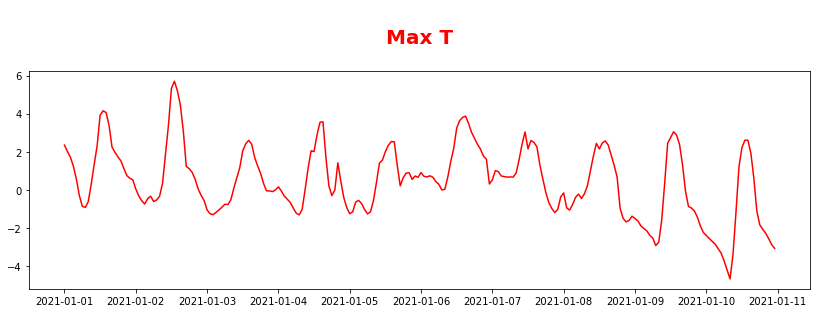

In [8]:
#test data
data = df.select("Datetime","Temperature").filter(df.Year == 2021).collect()
day = [i.Datetime for i in data]
MaxT_test_data = [i.Temperature for i in data]
MaxT_test_data_all = [i.Temperature for i in data]


plt.figure(figsize=(14,4))
plt.plot(day[0:240], MaxT_test_data[0:240], color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [9]:
# Rolling average, not really needed for later

df = df.withColumn('timestampGMT', df.Datetime.cast('timestamp'))

#create window by casting timestamp to long (number of seconds)
w = (Window.orderBy(F.col("timestampGMT").cast('long')).rowsBetween(-4, 0))

df = df.withColumn('rolling_average', F.avg("Temperature").over(w))

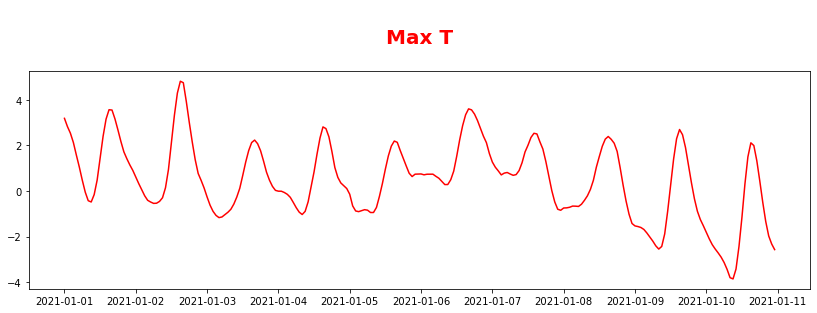

In [10]:
#test data
data = df.select("Datetime","rolling_average").filter(df.Year == 2021).collect()
day = [i.Datetime for i in data]
MaxT_test_data = [i.rolling_average for i in data]
MaxT_test_data_all = [i.rolling_average for i in data]


plt.figure(figsize=(14,4))
plt.plot(day[0:240], MaxT_test_data[0:240], color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

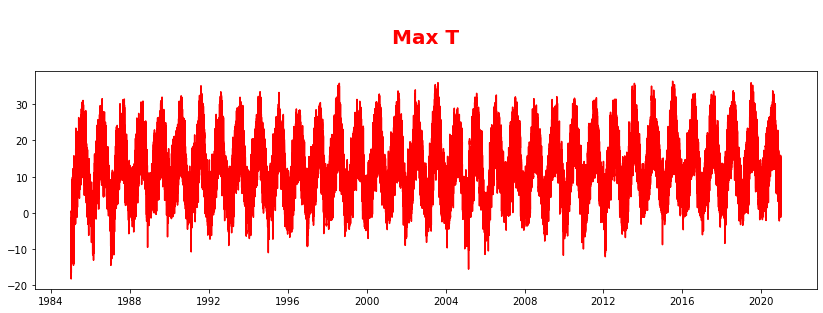

In [11]:
data = df.select("Datetime","rolling_average").filter(df.Year != 2021).collect()
day = [i.Datetime for i in data]
MaxT_training_data = [i.rolling_average for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_training_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [12]:
# groupying by month and year, needed for LSTM!!

df_clean = df.groupBy("Year", "Month")\
    .agg(max("Temperature").alias("MaxT"), \
         min("Temperature").alias("MinT"), \
         avg("Temperature").alias("AvgT"), \
         max("Wind").alias("MaxWind"), \
         avg("Wind").alias("AvgWind"), \
         max("Precipitation").alias("MaxRain"), \
         min("Precipitation").alias("MinRain"), \
         avg("Precipitation").alias("AvgRain"), \
         max("Humidity").alias("MaxHU"), \
         min("Humidity").alias("MinHU"), \
         avg("Humidity").alias("AvgHU"), \
         avg("Datetime").cast('timestamp').alias("Datetime"),\
        ).orderBy("Year", "Month") 

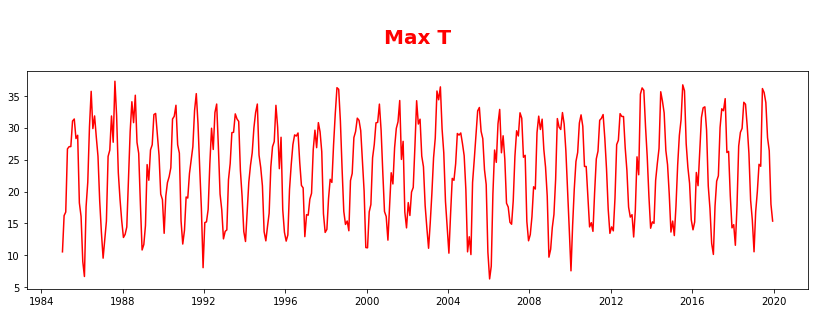

In [13]:
data = df_clean.select("Datetime","MaxT").filter((df.Year != 2021) & (df.Year != 2020)).collect()
day = [i.Datetime for i in data]
MaxT_training_data = [i.MaxT for i in data]

plt.figure(figsize=(14,4))
plt.plot(day, MaxT_training_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

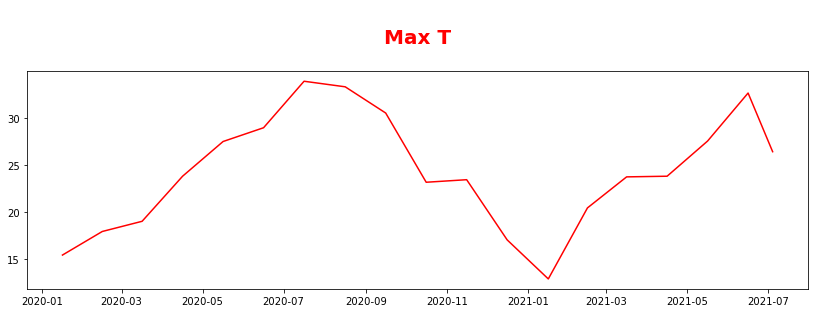

In [14]:
#test data
data = df_clean.select("Datetime","MaxT").filter((df.Year == 2021) | (df.Year == 2020)).collect()
dayTest = [i.Datetime for i in data]
MaxT_test_data = [i.MaxT for i in data]
MaxT_test_data_all = [i.MaxT for i in data]


plt.figure(figsize=(14,4))
plt.plot(dayTest, MaxT_test_data, color = 'red')
plt.title('\nMax T\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

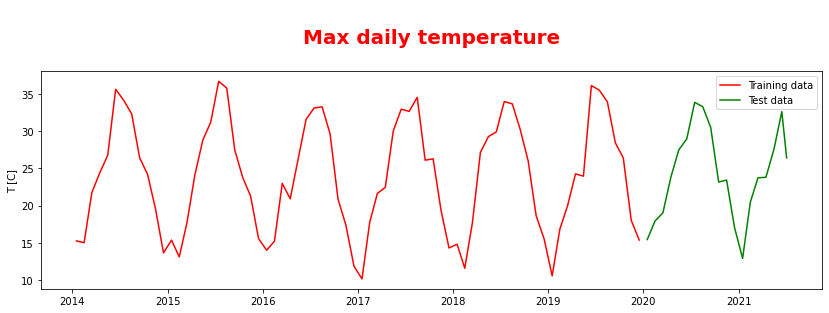

In [15]:

plt.figure(figsize=(14,4))
plt.plot(day[-72:], MaxT_training_data[-72:], label="Training data", color = 'red')

plt.plot(dayTest, MaxT_test_data, label="Test data", color = 'green')
plt.ylabel('T [C]')
plt.legend()


plt.title('\nMax daily temperature\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()

In [16]:
batch_size = 1

In [17]:
timesteps= 6

MaxT_test_data_CUT = MaxT_test_data


In [18]:
MaxT_training_data_CUT = MaxT_training_data



In [19]:

length  = (len(MaxT_training_data_CUT))-timesteps

In [20]:
# Set time steps to 7 days

# Adding timesteps * 2
upper_train = length + timesteps*2


In [21]:
# since bath size is 1, no shape adjustment are required

MaxT_training_data_enlarged = MaxT_training_data_CUT 


In [22]:
MaxT_training_data_enlarged = np.array(MaxT_training_data_enlarged)
MaxT_training_data_enlarged_reshaped = np.reshape(MaxT_training_data_enlarged, (MaxT_training_data_enlarged.shape[0],1))


In [23]:
#scale between 0 and 1. the weights are esier to find.
sc = MinMaxScaler(feature_range = (0, 1))
MaxT_training_data_enlarged_reshaped_scaled = sc.fit_transform(np.float64(MaxT_training_data_enlarged_reshaped))


In [24]:


# Empty Lists to store X_train and y_train
MaxT_training_data_X_matrix = []
MaxT_training_data_Y_matrix = []

# Creating a data structure with n timesteps
for i in range(timesteps, length ):
    #create X_train matrix
    MaxT_training_data_X_matrix.append(MaxT_training_data_enlarged_reshaped_scaled[i-timesteps:i,0])
    #create Y_train matrix
    MaxT_training_data_Y_matrix.append(MaxT_training_data_enlarged_reshaped_scaled[i:i+timesteps,0])
    

In [25]:
MaxT_training_data_X_matrix = np.array(MaxT_training_data_X_matrix) 
MaxT_training_data_Y_matrix = np.array(MaxT_training_data_Y_matrix) 
print(MaxT_training_data_X_matrix.shape)



# reshape arrays
MaxT_training_data_X_matrix = np.reshape(MaxT_training_data_X_matrix, 
                                         (MaxT_training_data_X_matrix.shape[0], 
                                          MaxT_training_data_X_matrix.shape[1], 1))

MaxT_training_data_Y_matrix = np.reshape(MaxT_training_data_Y_matrix, 
                                         (MaxT_training_data_Y_matrix.shape[0], 
                                         MaxT_training_data_Y_matrix.shape[1], 1))

(408, 6)


LSTM model and training are disabled, since they have been trained once and then the model has been saved.

In [26]:
regressor = load_model('./model_trained-monthly.h5')

In [27]:

test_length = len(MaxT_test_data_CUT)-timesteps

upper_test = test_length + timesteps*2


In [28]:
MaxT_test_data_1 = (MaxT_test_data_CUT) + MaxT_test_data_all[test_length:upper_test]



In [29]:

#subsetting
MaxT_test_data_CUT_enlarged = (MaxT_test_data_CUT) 
MaxT_test_data_CUT_enlarged_reshaped = np.array(MaxT_test_data_CUT_enlarged)
MaxT_test_data_CUT_enlarged_reshaped = np.reshape(MaxT_test_data_CUT_enlarged_reshaped, (MaxT_test_data_CUT_enlarged_reshaped.shape[0],1))
print(MaxT_test_data_CUT_enlarged_reshaped.shape)
#scaling
MaxT_test_data_CUT_enlarged_reshaped_scaled = sc.fit_transform(np.float64(MaxT_test_data_CUT_enlarged_reshaped))

#creating input data
X_test_matrix_test = []
for i in range(timesteps, test_length+timesteps):

    X_test_matrix_test.append(MaxT_test_data_CUT_enlarged_reshaped_scaled[i-timesteps:i, 0])
X_test_matrix_test = np.array(X_test_matrix_test)


#reshaping
X_test_matrix_test = np.reshape(X_test_matrix_test, 
                                         (X_test_matrix_test.shape[0], 
                                          timesteps, 1))



(19, 1)


In [30]:

prediction_y_hat = regressor.predict(X_test_matrix_test, batch_size=batch_size)
regressor.reset_states()

print('Predicted Set Shape:', prediction_y_hat.shape)

Predicted Set Shape: (13, 6, 1)


In [31]:
prediction_y_hat = np.reshape(prediction_y_hat, 
                                (prediction_y_hat.shape[0], 
                                prediction_y_hat.shape[1]))

print('Predicted Set Shape After reshaping:', prediction_y_hat.shape)
prediction_y_hat = sc.inverse_transform(prediction_y_hat)


Predicted Set Shape After reshaping: (13, 6)


In [32]:
#creating y_pred data
prediction_y_pred = []

for j in range(0, test_length ):

                            
    prediction_y_pred = np.append(prediction_y_pred, prediction_y_hat[j, 0])

# reshaping
prediction_y_pred = np.array(prediction_y_pred)
prediction_y_pred = np.reshape(prediction_y_pred, (prediction_y_pred.shape[0], 1))



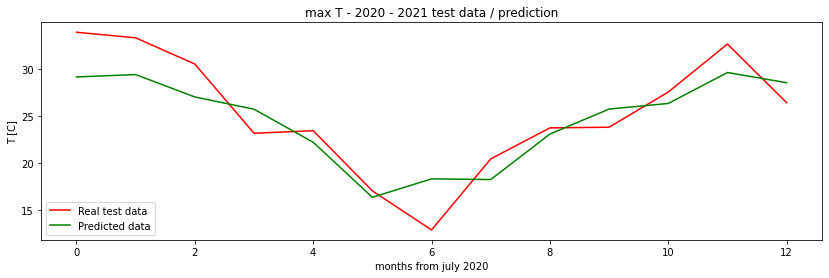

In [33]:
# Visualising the results

plt.figure(figsize=(14,4))

plt.plot(MaxT_test_data_CUT_enlarged_reshaped[timesteps:], color = 'red', label = 'Real test data')
plt.plot(prediction_y_pred[0:len(prediction_y_pred) ], color = 'green', label = 'Predicted data')
plt.title('max T - 2020 - 2021 test data / prediction')
plt.xlabel('months from july 2020')
plt.ylabel('T [C]')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:


RMSE= np.sqrt(mean_squared_error(MaxT_test_data_all[timesteps:len(prediction_y_pred)],prediction_y_pred[0:len(prediction_y_pred) - timesteps]))
print('RMSE:',RMSE)



RMSE: 3.538311769492701


In [36]:
mean= np.mean(MaxT_test_data_all[timesteps:len(prediction_y_pred)])
print(mean)
print(RMSE)
print('Loss: ' + str((RMSE/mean)*100 )+ '%') 



24.88624313899449
3.538311769492701
Loss: 14.217942618861931%


# Forecasting

In [51]:
prediction_y_forecast = []
print(test_length)
for j in range(0, test_length ):

                            
    prediction_y_forecast = np.append(prediction_y_forecast, prediction_y_hat[j, -1])

# reshaping
prediction_y_forecast = np.array(prediction_y_forecast)

prediction_y_forecast = np.reshape(prediction_y_forecast, (prediction_y_forecast.shape[0], 1))

13


In [60]:

start = pd.Timestamp('2021-08-01')
end = pd.Timestamp('2022-01-01')
t = np.linspace(start.value, end.value, 6)
t = pd.to_datetime(t)
print(t)

DatetimeIndex(['2021-08-01 00:00:00', '2021-08-31 14:24:00',
               '2021-10-01 04:48:00', '2021-10-31 19:12:00',
               '2021-12-01 09:36:00', '2022-01-01 00:00:00'],
              dtype='datetime64[ns]', freq=None)


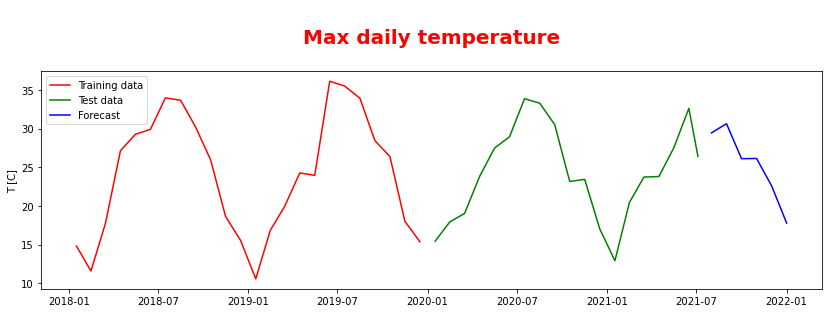

In [62]:
plt.figure(figsize=(14,4))
plt.plot(day[-24:], MaxT_training_data[-24:], label="Training data", color = 'red')

plt.plot(dayTest, MaxT_test_data, label="Test data", color = 'green')
plt.plot(t, prediction_y_forecast[7:], label="Forecast", color = 'blue')

plt.ylabel('T [C]')
plt.legend()


plt.title('\nMax daily temperature\n', fontsize=20, fontweight='bold' , color = 'red')
plt.show()